In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Replace with your actual folder path
base_path = "/content/drive/MyDrive/flood-dataset"  # Example
image_dir = os.path.join(base_path, "Image")       # e.g., JPEGs or PNGs
mask_dir = os.path.join(base_path, "Mask")         # binary masks

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_HEIGHT = 256
IMG_WIDTH = 256

def load_flood_image(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = image / 255.0  # Normalize to [0, 1]
    return image

def load_flood_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    mask = mask / 255.0    # Convert to binary float
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    return mask

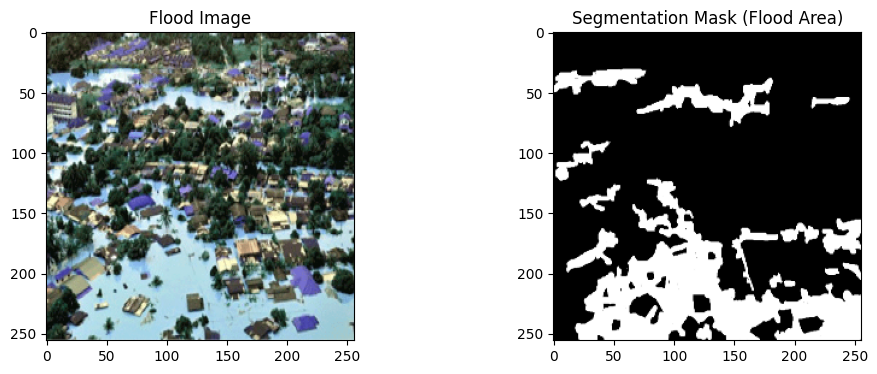

In [ ]:
# Pick one sample file
sample_image_path = os.path.join(image_dir, os.listdir(image_dir)[0])
sample_mask_path = os.path.join(mask_dir, os.listdir(mask_dir)[0])

image = load_flood_image("/content/drive/MyDrive/flood-dataset/Image/0.jpg")
mask = load_flood_mask("/content/drive/MyDrive/flood-dataset/Mask/0.png")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Flood Image")
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title("Segmentation Mask (Flood Area)")
plt.imshow(mask.squeeze(), cmap='gray')
plt.show()

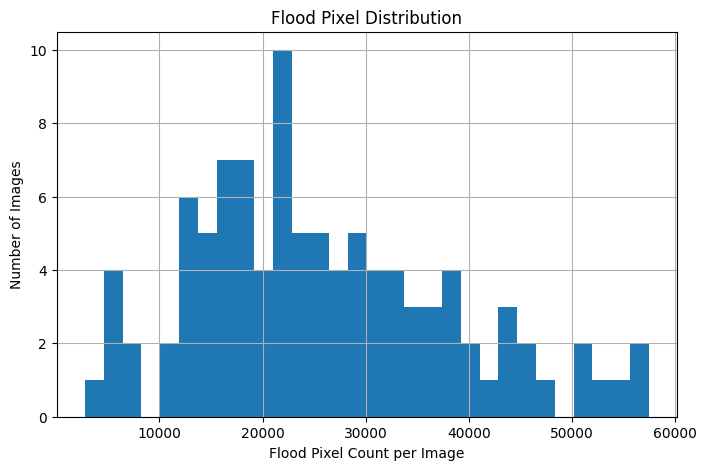

In [ ]:
import glob

mask_paths = glob.glob(os.path.join(mask_dir, "*.png"))[:100]  # Adjust extension

pixel_counts = []

for m in mask_paths:
    m_data = load_flood_mask(m)
    pixel_counts.append(np.sum(m_data))

plt.figure(figsize=(8, 5))
plt.hist(pixel_counts, bins=30)
plt.title("Flood Pixel Distribution")
plt.xlabel("Flood Pixel Count per Image")
plt.ylabel("Number of Images")
plt.grid(True)
plt.show()

In [ ]:
print(f"Total Images: {len(os.listdir(image_dir))}")
print(f"Total Masks: {len(os.listdir(mask_dir))}")
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}, Unique values: {np.unique(mask)}")

Total Images: 290
Total Masks: 290
Image shape: (256, 256, 3)
Mask shape: (256, 256, 1), Unique values: [0.         0.00392157 0.00784314 0.01176471 0.01568627 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313725
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.0745098  0.07843137 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196078 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941176 0.13333333 0.1372549
 0.14117647 0.14509804 0.14901961 0.15294118 0.15686275 0.16078431
 0.16470588 0.16862745 0.17254902 0.17647059 0.18039216 0.18431373
 0.18823529 0.19215686 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568627 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313725 0.24705882 0.25098039 0.25490196
 0.25882353 0.2627451  0.26666667 0.27058824 0.2745098  0.27843137
 0.28235294 0.28627451 0.29019608 0.29411765 0.29803922 0.30196078
 0.30588235 0.30980392 0.3

In [ ]:
import os

# Set your dataset paths
image_dir = "/content/drive/MyDrive/flood-dataset/Image"
mask_dir = "/content/drive/MyDrive/flood-dataset/Mask"

# List files and strip extensions
image_names = [os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
mask_names = [os.path.splitext(f)[0] for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg'))]

# Convert to sets for comparison
image_set = set(image_names)
mask_set = set(mask_names)

# Find matched and unmatched
matched_names = sorted(image_set & mask_set)
only_images = sorted(image_set - mask_set)
only_masks = sorted(mask_set - image_set)

# Print summary
print(f"✅ Matched Pairs: {len(matched_names)}")
print(f"❌ Unmatched Images: {len(only_images)}")
print(f"❌ Unmatched Masks: {len(only_masks)}")

# Optional: Show mismatches
if only_images:
    print("\nImages with no corresponding mask:")
    for name in only_images:
        print(name)

if only_masks:
    print("\nMasks with no corresponding image:")
    for name in only_masks:
        print(name)


✅ Matched Pairs: 290
❌ Unmatched Images: 0
❌ Unmatched Masks: 0


In [ ]:
# Delete unmatched images
for name in only_images:
    for ext in ['.jpg', '.png', '.jpeg']:
        image_path = os.path.join(image_dir, name + ext)
        if os.path.exists(image_path):
            os.remove(image_path)
            print(f"Deleted image: {image_path}")

# Delete unmatched masks
for name in only_masks:
    for ext in ['.png', '.jpg', '.jpeg']:
        mask_path = os.path.join(mask_dir, name + ext)
        if os.path.exists(mask_path):
            os.remove(mask_path)
            print(f"Deleted mask: {mask_path}")


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Root dataset path in Google Drive
base_path = "/content/drive/MyDrive/flood-dataset"  # change if needed

# Original folders
image_dir = os.path.join(base_path, "Image")
mask_dir = os.path.join(base_path, "Mask")

# Output folders
splits = ["train", "val", "test"]
for split in splits:
    os.makedirs(os.path.join(base_path, split, "Image"), exist_ok=True)
    os.makedirs(os.path.join(base_path, split, "Mask"), exist_ok=True)

# List image and mask files (ensure they align)
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

# Full paths
image_paths = [os.path.join(image_dir, f) for f in image_files]
mask_paths = [os.path.join(mask_dir, f) for f in mask_files]

# First split: train (70%) and temp (30%)
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    image_paths, mask_paths, test_size=0.3, random_state=42
)

# Split temp into val (15%) and test (15%)
val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.5, random_state=42
)

# Helper function
def copy_files(images, masks, split):
    for img, mask in zip(images, masks):
        shutil.copy(img, os.path.join(base_path, split, "Image", os.path.basename(img)))
        shutil.copy(mask, os.path.join(base_path, split, "Mask", os.path.basename(mask)))

# Copy files
copy_files(train_imgs, train_masks, "train")
copy_files(val_imgs, val_masks, "val")
copy_files(test_imgs, test_masks, "test")

print("✅ Dataset successfully split into train, val, and test sets.")


✅ Dataset successfully split into train, val, and test sets.


In [ ]:
!pip install -U tensorflow

  Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (644.9 MB)
Using cached keras-3.10.0-py3-none-any.whl (1.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def build_unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)

    # Bottleneck
    b1 = Conv2D(128, 3, activation='relu', padding='same')(p3)
    b1 = Conv2D(128, 3, activation='relu', padding='same')(b1)

    # Decoder
    u1 = Conv2DTranspose(64, 2, strides=2, padding='same')(b1)
    u1 = concatenate([u1, c3])
    c4 = Conv2D(64, 3, activation='relu', padding='same')(u1)
    c4 = Conv2D(64, 3, activation='relu', padding='same')(c4)

    u2 = Conv2DTranspose(32, 2, strides=2, padding='same')(c4)
    u2 = concatenate([u2, c2])
    c5 = Conv2D(32, 3, activation='relu', padding='same')(u2)
    c5 = Conv2D(32, 3, activation='relu', padding='same')(c5)

    u3 = Conv2DTranspose(16, 2, strides=2, padding='same')(c5)
    u3 = concatenate([u3, c1])
    c6 = Conv2D(16, 3, activation='relu', padding='same')(u3)
    c6 = Conv2D(16, 3, activation='relu', padding='same')(c6)

    outputs = Conv2D(1, 1, activation='sigmoid')(c6)

    model = Model(inputs, outputs)
    return model


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Gather file paths
image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

# Train/val split
train_images, val_images, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

# Data generator
def data_gen(image_list, mask_list, batch_size=8):
    while True:
        for i in range(0, len(image_list), batch_size):
            batch_images = image_list[i:i+batch_size]
            batch_masks = mask_list[i:i+batch_size]

            imgs = np.array([load_flood_image(p) for p in batch_images])
            masks = np.array([load_flood_mask(p) for p in batch_masks])

            yield imgs, masks


In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf

def iou_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

def dice_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [ ]:
model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou_coef, dice_coef])

batch_size = 8
train_gen = data_gen(train_images, train_masks, batch_size)
val_gen = data_gen(val_images, val_masks, batch_size)

steps_per_epoch = len(train_images) // batch_size
val_steps = len(val_images) // batch_size

history = model.fit(train_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - dice_coef: 0.4259 - iou_coef: 0.2714 - loss: 0.6757 - val_dice_coef: 0.4955 - val_iou_coef: 0.3305 - val_loss: 0.5254
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - dice_coef: 0.5100 - iou_coef: 0.3434 - loss: 0.5569 - val_dice_coef: 0.4717 - val_iou_coef: 0.3093 - val_loss: 0.6891
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - dice_coef: 0.4485 - iou_coef: 0.2915 - loss: 0.6983 - val_dice_coef: 0.4340 - val_iou_coef: 0.2776 - val_loss: 0.6119
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - dice_coef: 0.4680 - iou_coef: 0.3062 - loss: 0.5768 - val_dice_coef: 0.5622 - val_iou_coef: 0.3922 - val_loss: 0.4788
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - dice_coef: 0.5467 - iou_coef: 0.3776 - loss: 0.5042 - val_dice_coef: 0.5820 - val_iou_coef: 0.4120 - val_loss: 0.4599
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - dice_coef: 0.5761 - iou_coef: 0.4058 - loss: 0.4770 - val_dice_coef: 0.6063 - val_iou_coef: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


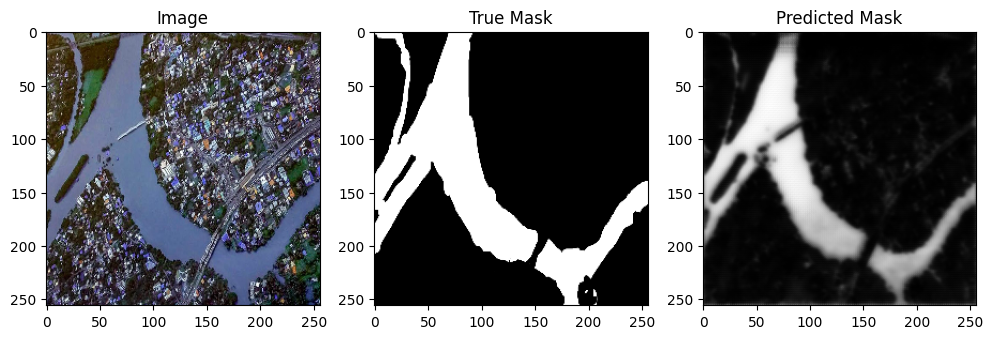

In [ ]:
# Predict and visualize
val_image = load_flood_image(val_images[0])
val_mask = load_flood_mask(val_masks[0])
pred_mask = model.predict(np.expand_dims(val_image, axis=0))[0]

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(val_image)

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(val_mask.squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.show()

In [ ]:
# Save the full model (architecture + weights + optimizer state)
model.save('/content/drive/MyDrive/disaster_model_week2.h5')

print("✅ Week 2 model saved at: /content/drive/MyDrive/disaster_model_week2.h5")

✅ Week 2 model saved at: /content/drive/MyDrive/disaster_model_week2.h5
